In [1]:
# Import functions from the STIFMaps package
from STIFMaps import STIFMap_generation
from STIFMaps.misc import get_step

In [2]:
# Other imports
import os
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from scipy import interpolate

import time

# Generate STIFMap(s) for an image of interest

### Specify input files

In [3]:
# Specify the DAPI and collagen images to be overlaid
dapi = '/path/to/test1_DAPI.TIF'
collagen = '/path/to/test1_collagen.TIF'


# If saving, what should the sample be called?
name = 'test'

# Specify the models to use
model_dir = '/path/to/trained_models/'
models = [model_dir+model for model in os.listdir(model_dir)]

models

['/home/connor/Documents/STIFMaps/trained_models/iteration_1002.pt',
 '/home/connor/Documents/STIFMaps/trained_models/iteration_1003.pt',
 '/home/connor/Documents/STIFMaps/trained_models/iteration_1000.pt',
 '/home/connor/Documents/STIFMaps/trained_models/iteration_1004.pt',
 '/home/connor/Documents/STIFMaps/trained_models/iteration_1001.pt']

### Specify Parameters

In [4]:
# Networks were trained at a microscopy resolution of 4.160 pixels/micron (0.2404 microns/pixel)
# Provide a scale factor to resize the input images to this resolution
# Ex: Images at 2.308 pixels/micron require a scale_factor of 1.802
scale_factor = 1.802

# Stifness is predicted for each square. This is the distance from the center of one square to the next
step = 40

# How many squares to evaluate at once with the network
batch_size = 100

### Given the scale_factor, what are the actual square dimensions and step sizes that will be used?

In [5]:
# Given the scale_factor, what is the actual step size (in pixels) from one square to the next?
step = get_step(step, scale_factor)

print('Step size is ' + str(step) + ' pixels')

# Get the actual side length of one square
# (224 corresponds to the side length (in pixels) of the original images used to train the model)
square_side = get_step(224, scale_factor)

print('Side length for a square is ' + str(square_side) + ' pixels')

Step size is 22 pixels
Side length for a square is 124 pixels


### Get STIFMap

Device is cpu
Image shape is (3, 1024, 1024)
Num squares in x direction is 41
Num squares in y direction is 41
Time taken to predict squares is 10.687923192977905
Time taken to predict squares is 30.26777935028076
Time taken to predict squares is 57.83334231376648
Time taken to predict squares is 91.71627020835876
Time taken to predict squares is 120.19001698493958
Total time taken is 120.40911555290222


/home/connor/anaconda3/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


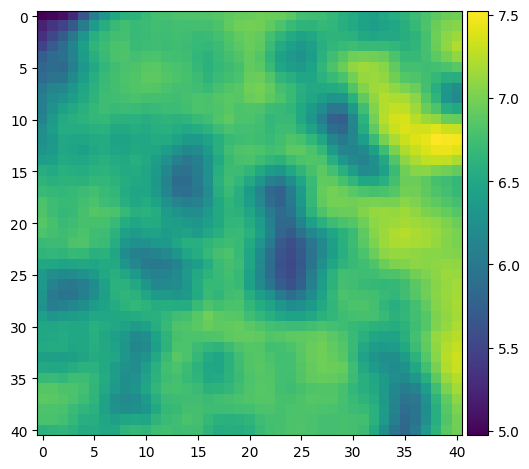

In [6]:
z_out = STIFMap_generation.generate_STIFMap(dapi, collagen, name, step, models=models,
                    mask=False, batch_size=100, square_side=square_side,
                    save_dir=False)

# Show the output image
io.imshow(np.mean(z_out, axis=0))

# Collagen Painting

## (Pseudocolor the collagen to indicate the predicted stiffness)

### Specify parameters

In [7]:
# The pixel threshold to use when comparing STIFMaps/DAPI/GFP vs stain intensity
quantile = .99

# used to downsample images if the full images use too much memory
scale_percent = 100

test
Time taken is 0.16808485984802246


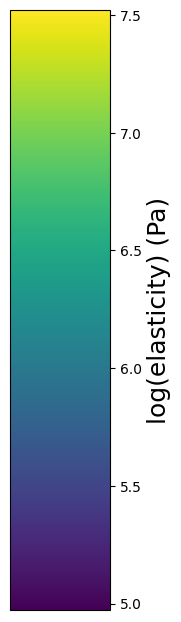

In [8]:
col_colored = STIFMap_generation.collagen_paint(dapi, collagen, z_out, name, step,
                    mask=False, square_side=square_side, quantile=quantile,
                    scale_percent=scale_percent, save_dir=False)

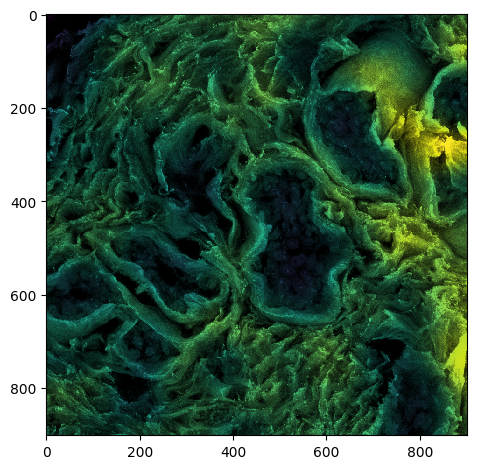

In [9]:
# Show the pseudocolored collagen image
io.imshow(col_colored)

# Correlate predicted stiffness with a staining marker of interest

In [10]:
# Specify the staining file to use
stain = '/path/to/test1_stain.TIF'

In [11]:
_, _, _ = STIFMap_generation.correlate_signals_with_stain(dapi, collagen, z_out, stain, step,
                                                mask=False, square_side=square_side, quantile=quantile)

Spearman correlation between stain and predicted stiffness is 0.9439506073361753
Spearman correlation between stain and collagen is 0.8344031649550415
Spearman correlation between stain and dapi is -0.2181906103088438
time taken is 38.69330954551697
